##Imports 

Import all the common libraries that will be used 

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

##Download and prep the dataset 
Download the `plain_text` version of the `IMDB Reviews` dataset

In [4]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZRTDNU/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZRTDNU/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZRTDNU/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
#Get the train and test datasets 
train_data, test_data = imdb['train'], imdb['test']

#Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

#Loop over the training examples and save the sentences and labels
for s, l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

#Loop over the test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())


#Convert the labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

Unlike the sub word encoded set used in the previous lab, you will need to build the vocabulary from scratch and generate padded sequences 

You can accomplish this using the `Tokenizer` class and the `pad_sequences` method

In [6]:
#parameters 
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

#Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

#Generate the word index dictionary for the training sentences 
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

#Generate and pad the training sequences 
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

#Generate and pad the test sequences 
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

##Plot Utility
Before defining the models, define the function belwo so that you can easily visualize the accuracy and loss history after training 

In [7]:
import matplotlib.pyplot as plt

#Plot Function
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

##Model 1: Flatten

First simply using a flatten layer after embedding. Its main advantage is that it is very fast to train 

In [10]:
#Parameters 
embedding_dim = 16
dense_dim = 6

#Model definition with a Flatten layer 
model_flatten = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_dim, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

#Set the training parameters 
model_flatten.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_flatten.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 11526     
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

#Train the model 
history_flatten = model_flatten.fit(padded, 
                                    training_labels_final, 
                                    batch_size = BATCH_SIZE,
                                    epochs = NUM_EPOCHS,
                                    validation_data = (testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0183 - accuracy: 0.9989 - val_loss: 0.5123 - val_accuracy: 0.8324
Epoch 2/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0092 - accuracy: 0.9996 - val_loss: 0.5401 - val_accuracy: 0.8308
Epoch 3/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.5623 - val_accuracy: 0.8333
Epoch 4/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.5904 - val_accuracy: 0.8326
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6121 - val_accuracy: 0.8322
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6344 - val_accuracy: 0.8320
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.6487 - val_accuracy: 0.8326
Ep

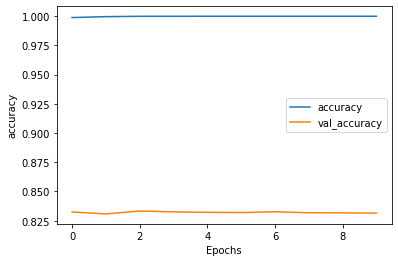

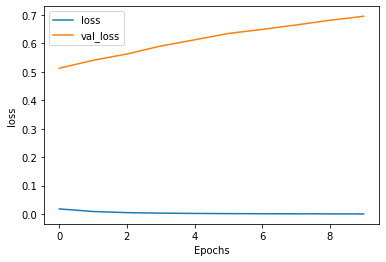

In [15]:
#Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

##LSTM
Next use an LSTM layer

This is slower to train, but useful in applications where the order of the tokens is important 

In [16]:
#Parameters 
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

#Model Definition with LSTM
model_lstm = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), 
      tf.keras.layers.Dense(dense_dim, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

#Set the training parameters 
model_lstm.compile(loss = 'binary_crossentropy',
                   optimizer = 'adam',
                   metrics = ['accuracy'],
                   )

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [18]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

#Train the model
history_lstm = model_lstm.fit(padded,
                              training_labels_final,
                              batch_size = BATCH_SIZE,
                              epochs = NUM_EPOCHS,
                              validation_data = (testing_padded, testing_labels_final)
                              )

Epoch 1/10
196/196 [==============================] - 46s 213ms/step - loss: 0.5329 - accuracy: 0.7080 - val_loss: 0.3521 - val_accuracy: 0.8476
Epoch 2/10
196/196 [==============================] - 34s 172ms/step - loss: 0.3134 - accuracy: 0.8723 - val_loss: 0.3853 - val_accuracy: 0.8419
Epoch 3/10
196/196 [==============================] - 35s 179ms/step - loss: 0.2455 - accuracy: 0.9041 - val_loss: 0.3746 - val_accuracy: 0.8418
Epoch 4/10
196/196 [==============================] - 35s 178ms/step - loss: 0.2029 - accuracy: 0.9268 - val_loss: 0.4411 - val_accuracy: 0.8283
Epoch 5/10
196/196 [==============================] - 34s 176ms/step - loss: 0.1739 - accuracy: 0.9364 - val_loss: 0.4691 - val_accuracy: 0.8259
Epoch 6/10
196/196 [==============================] - 34s 173ms/step - loss: 0.1503 - accuracy: 0.9485 - val_loss: 0.4594 - val_accuracy: 0.8264
Epoch 7/10
196/196 [==============================] - 34s 172ms/step - loss: 0.1180 - accuracy: 0.9617 - val_loss: 0.5460 - val_ac

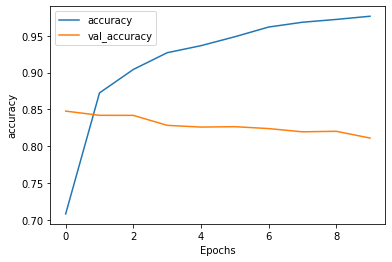

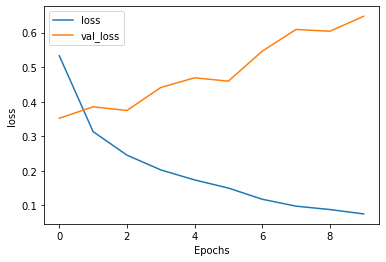

In [19]:
#Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

##GRU
The Gated Recurrent Unit or `GRU` is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. It's a bit smaller than LSTM and it trains faster by a few seconds 

In [20]:
import tensorflow as tf

#parameters 
embedding_dim = 16
gru_dim = 32
dense_dim = 6

#Model definition with GRU
model_gru = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
      tf.keras.layers.Dense(dense_dim, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

#Set the training parameters 
model_gru.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])


model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [21]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

#Train the model
history_gru = model_gru.fit(padded, 
                            training_labels_final, 
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            validation_data = (testing_padded, testing_labels_final)
                            )

Epoch 1/10
196/196 [==============================] - 49s 226ms/step - loss: 0.5835 - accuracy: 0.6570 - val_loss: 0.3602 - val_accuracy: 0.8450
Epoch 2/10
196/196 [==============================] - 39s 198ms/step - loss: 0.3114 - accuracy: 0.8712 - val_loss: 0.3475 - val_accuracy: 0.8491
Epoch 3/10
196/196 [==============================] - 41s 212ms/step - loss: 0.2355 - accuracy: 0.9105 - val_loss: 0.3660 - val_accuracy: 0.8453
Epoch 4/10
196/196 [==============================] - 42s 213ms/step - loss: 0.1898 - accuracy: 0.9305 - val_loss: 0.3873 - val_accuracy: 0.8389
Epoch 5/10
196/196 [==============================] - 51s 261ms/step - loss: 0.1553 - accuracy: 0.9459 - val_loss: 0.5135 - val_accuracy: 0.8283
Epoch 6/10
196/196 [==============================] - 49s 252ms/step - loss: 0.1218 - accuracy: 0.9592 - val_loss: 0.4865 - val_accuracy: 0.8249
Epoch 7/10
196/196 [==============================] - 46s 233ms/step - loss: 0.0962 - accuracy: 0.9678 - val_loss: 0.6155 - val_ac

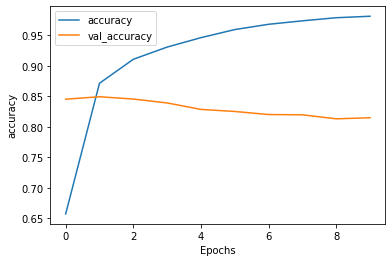

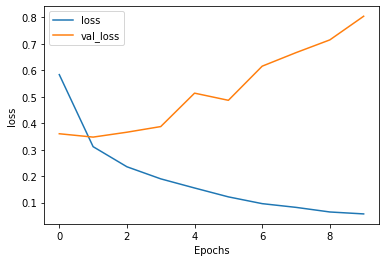

In [22]:
#Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

##Convolution
Lastly you will use a convolutional layer to extract features from your datasets. Append a `GlobalAveragePooling1d` layer to reduce the results before passing it on to the dense layers. 

Like with the model with `Flatten` this also trains much faster than the ones using RNN layes like `LSTM` and 'GRU'

In [23]:
#Parameters 
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

#Model definition with Conv1D
model_conv = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
      tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(dense_dim, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

#Set the training parameters 
model_conv.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


model_conv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [25]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

#Train the model 
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 10s 48ms/step - loss: 0.5189 - accuracy: 0.7415 - val_loss: 0.3655 - val_accuracy: 0.8401
Epoch 2/10
196/196 [==============================] - 10s 52ms/step - loss: 0.2971 - accuracy: 0.8774 - val_loss: 0.3473 - val_accuracy: 0.8502
Epoch 3/10
196/196 [==============================] - 10s 49ms/step - loss: 0.2380 - accuracy: 0.9069 - val_loss: 0.3759 - val_accuracy: 0.8430
Epoch 4/10
196/196 [==============================] - 9s 47ms/step - loss: 0.2045 - accuracy: 0.9228 - val_loss: 0.4079 - val_accuracy: 0.8362
Epoch 5/10
196/196 [==============================] - 9s 48ms/step - loss: 0.1781 - accuracy: 0.9340 - val_loss: 0.4588 - val_accuracy: 0.8258
Epoch 6/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1564 - accuracy: 0.9448 - val_loss: 0.5041 - val_accuracy: 0.8224
Epoch 7/10
196/196 [==============================] - 10s 50ms/step - loss: 0.1380 - accuracy: 0.9536 - val_loss: 0.5504 - val_accuracy: 0.

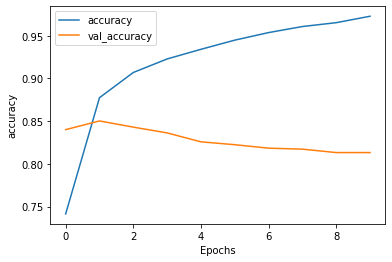

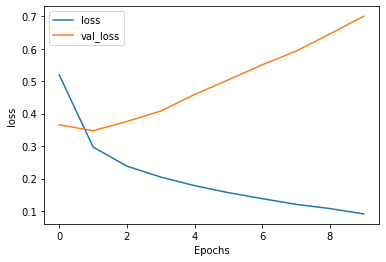

In [26]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')